In [1]:
## Instalowanie modułów

# !pip3 install --upgrade pip

# !pip3 install -U gym
# !pip3 install -U numpy
# !pip3 install -U matplotlib
# !pip3 install -U pandas
# !pip3 install -U jinja2

In [2]:
## Importowanie modułów

import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from collections import deque


In [3]:
## Implementacja algorytmu Q-learning

def q_learning(env, alpha, gamma, epsilon, episodes, max_steps, boltzmann, T=1.0, seed=None):
    rewards = []
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    
    if seed is not None:
        env.reset(seed=seed)

    for _ in range(episodes):
        state, _ = env.reset()  # observation, info
        total_rewards = 0
        
        for step in range(max_steps):
            if boltzmann:
                exp_values = np.exp(q_table[state] / T)
                probabilities = exp_values / np.sum(exp_values)
                action = np.random.choice(np.arange(len(probabilities)), p=probabilities)
            else:
                if np.random.uniform(0, 1) < epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(q_table[state])
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_rewards += reward
            
            best_next_action = np.argmax(q_table[next_state])
            td_target = reward + gamma * q_table[next_state][best_next_action]
            td_error = td_target - q_table[state][action]
            q_table[state][action] += alpha * td_error

            
            state = next_state
            
            if terminated or truncated:
                break
        
        rewards.append(total_rewards)
    
    return q_table, rewards

In [4]:
## Inna próba implementacji algorytmu Q-learning (z wykładu)

def q_learning_v2(t_max, gamma, beta, e_max):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    e = 0
    
    while e < e_max:
        state = env.reset()
        terminated = False
        t = 0
        
        while not terminated:
            if np.random.uniform(0, 1) < beta:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
            
            next_state, reward, terminated, _ = env.step(action)
            q_table[state][action] = q_table[state][action] + gamma * (reward + np.max(q_table[next_state]) - q_table[state][action])
            state = next_state
            t += 1
            
            if t >= t_max:
                break
        
        e += 1
    
    return q_table

In [5]:
## Przebieg eksperymentu

def run_experiments(env, params, episodes, max_steps, boltzmann, seed=None):
    results = {}
    for param_name, param_values in params.items():
        results[param_name] = []
        for value in param_values:
            if param_name == 'alpha':
                q_table, rewards = q_learning(env, alpha=value, gamma=0.8, epsilon=0.5, episodes=episodes, max_steps=max_steps, boltzmann=boltzmann, seed=seed)
            elif param_name == 'gamma':
                q_table, rewards = q_learning(env, alpha=0.1, gamma=value, epsilon=0.5, episodes=episodes, max_steps=max_steps, boltzmann=boltzmann, seed=seed)
            elif param_name == 'epsilon':
                q_table, rewards = q_learning(env, alpha=0.1, gamma=0.8, epsilon=value, episodes=episodes, max_steps=max_steps, boltzmann=boltzmann, seed=seed)
            elif param_name == 'T':
                q_table, rewards = q_learning(env, alpha=0.1, gamma=0.8, epsilon=0.5, episodes=episodes, max_steps=max_steps, boltzmann=True, T=value, seed=seed)
            results[param_name].append((value, rewards))
            # if any(reward != 0.0 for reward in rewards):
            #     print(f'{param_name} Rewards: {rewards}')
    return results

In [6]:
##  Wyświetlanie wyników

# def plot_results(results, param_name):
#     plt.figure(figsize=(12, 8))
#     for value, rewards in results[param_name]:
#         plt.plot(rewards, label=f'{param_name} = {value}')
#     plt.xlabel('Episodes')
#     plt.ylabel('Total Rewards')
#     plt.legend()
#     plt.title(f'Impact of {param_name} on Learning Convergence')
#     plt.show()

# def summarize_results(results, param_name):
#     summary = []
#     for value, rewards in results[param_name]:
#         mean_reward = np.mean(rewards[-10:])
#         std_reward = np.std(rewards[-10:])
#         success_rate = sum(reward > 0 for reward in rewards[-10:]) / 10
#         summary.append((value, mean_reward, std_reward, success_rate))
#     return summary

# def print_summary(summary, param_name):
#     print(f'\nSummary for {param_name}:')
#     print(f'{"Value":<10}{"Mean Reward":<15}{"Std Reward":<15}{"Success Rate":<15}')
#     for value, mean_reward, std_reward, success_rate in summary:
#         print(f'{value:<10}{mean_reward:<15}{std_reward:<15}{success_rate:<15}')


In [7]:
## Wyniki eksperymentów

def plot_results(results, param_name):
    plt.figure(figsize=(10, 5))
    
    for value, rewards in results[param_name]:
        avg_rewards = np.convolve(rewards, np.ones((10,))/10, mode='valid')
        plt.plot(avg_rewards, label=f'{param_name}={value}')
    
    plt.title(f'Average Reward on {param_name}')
    plt.xlabel('Training Epochs')
    plt.ylabel('Average Reward per Episode')
    plt.legend()
    plt.show()

def summarize_results(results):
    summary_data = []

    for param_name, experiments in results.items():
        for value, rewards in experiments:
            last_10_rewards = rewards[-10:]
            mean_reward = np.mean(last_10_rewards)
            std_reward = np.std(last_10_rewards)
            success_count = sum(1 for r in last_10_rewards if r > 0)
            summary_data.append([param_name, value, mean_reward, std_reward, success_count])
    
    summary_df = pd.DataFrame(summary_data, columns=['Parameter', 'Value', 'Mean Reward', 'Std Reward', 'Success Count'])
    return summary_df

def run_multiple_experiments(env, params, episodes, max_steps, boltzmann, seeds):
    all_results = {param_name: [] for param_name in params.keys()}
    
    for seed in seeds:
        np.random.seed(seed)
        random.seed(seed)
        
        results = run_experiments(env, params, episodes, max_steps, boltzmann)
        for param_name, experiments in results.items():
            if not all_results[param_name]:
                all_results[param_name] = [(value, []) for value, _ in experiments]
            
            for i, (value, rewards) in enumerate(experiments):
                all_results[param_name][i][1].append(rewards)
    
    # Calculate mean and std for rewards
    final_results = {param_name: [] for param_name in params.keys()}
    for param_name, experiments in all_results.items():
        for value, rewards_list in experiments:
            avg_rewards = np.mean(rewards_list, axis=0)
            std_rewards = np.std(rewards_list, axis=0)
            final_results[param_name].append((value, avg_rewards, std_rewards))
    
    return final_results


/Volumes/Dock/Git/WSI_24L/Zadanie6/zadanie6env/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


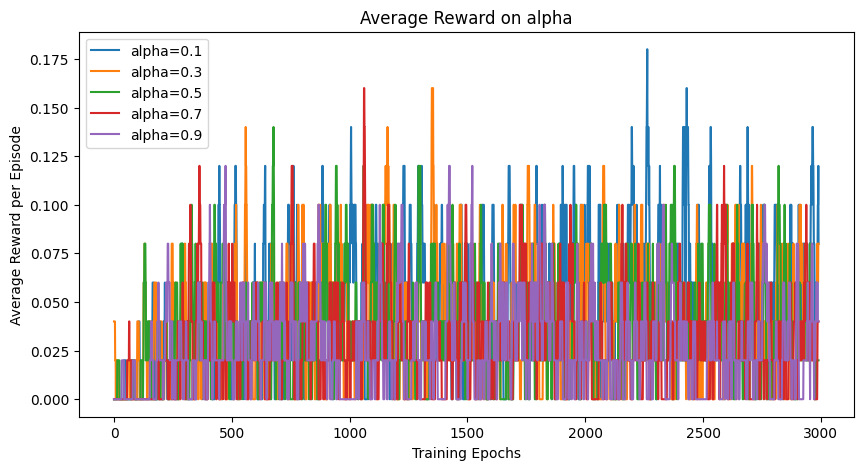

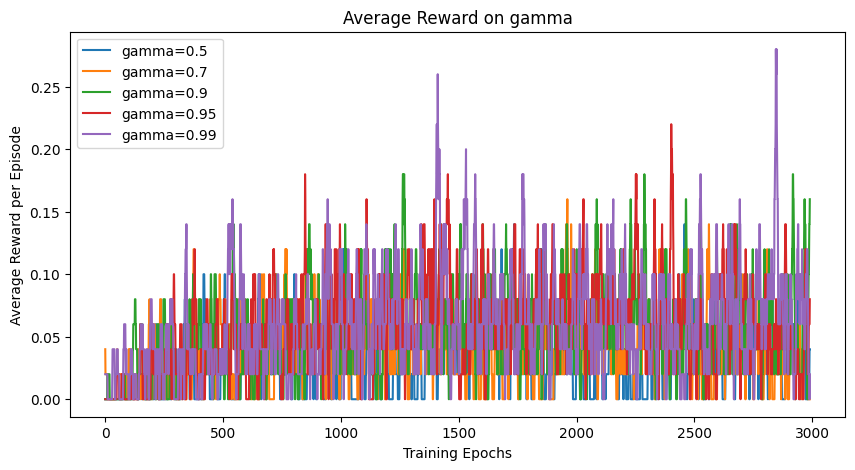

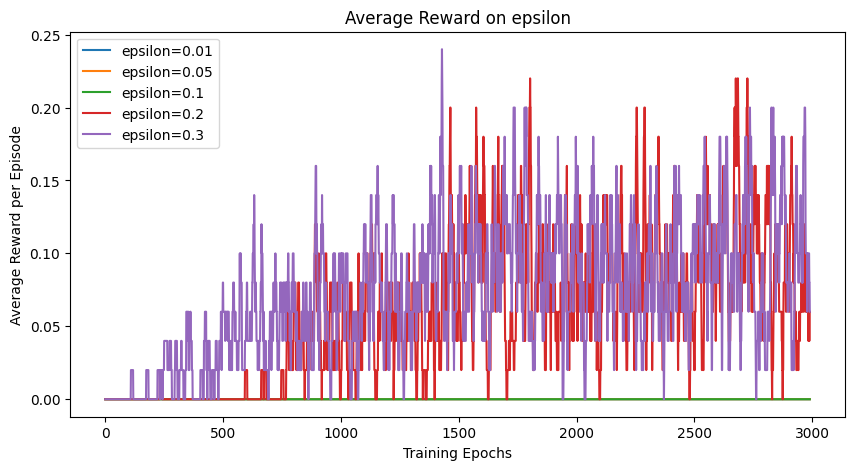

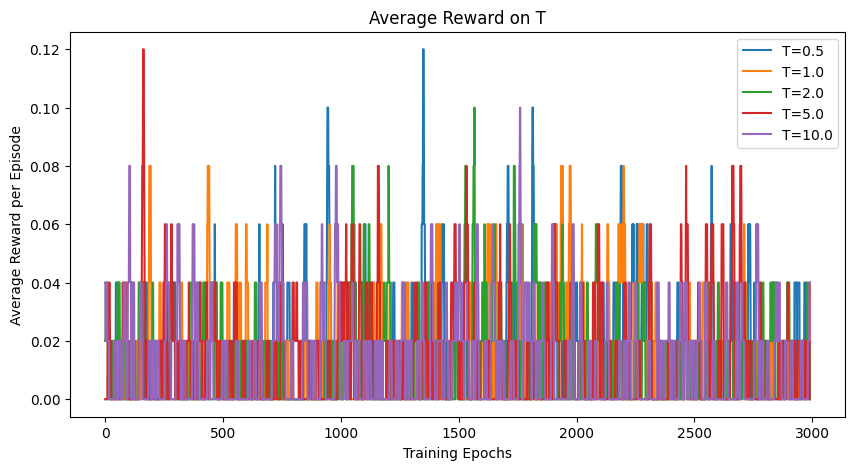

   Parameter  Value  Mean Reward  Std Reward  Success Count
0      alpha   0.10         0.08    0.132665              3
1      alpha   0.30         0.08    0.132665              3
2      alpha   0.50         0.02    0.060000              1
3      alpha   0.70         0.04    0.080000              2
4      alpha   0.90         0.04    0.080000              2
5      gamma   0.50         0.04    0.080000              2
6      gamma   0.70         0.00    0.000000              0
7      gamma   0.90         0.16    0.174356              6
8      gamma   0.95         0.08    0.097980              4
9      gamma   0.99         0.02    0.060000              1
10   epsilon   0.01         0.00    0.000000              0
11   epsilon   0.05         0.00    0.000000              0
12   epsilon   0.10         0.00    0.000000              0
13   epsilon   0.20         0.06    0.091652              3
14   epsilon   0.30         0.06    0.091652              3
15         T   0.50         0.00    0.00

In [8]:
## Przeprowadzenie eksperymentów

env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)    # 4 x4 false

# debug code
# observation, info = env.reset()
# counter = 0

# for _ in range(1000):
#     action = env.action_space.sample()
#     observation, reward, terminated, truncated, info = env.step(action)
#     if reward > 0:
#         counter += 1

#         print(f'Action: {action}, Observation: {observation}, Reward: {reward}, Terminated: {terminated}, Truncated: {truncated}')

#     if terminated or truncated:
#         observation, info = env.reset()

# env.close()

params = {
    'alpha': [0.1, 0.3, 0.5, 0.7, 0.9],
    'gamma': [0.5, 0.7, 0.9, 0.95, 0.99],
    'epsilon': [0.01, 0.05, 0.1, 0.2, 0.3],
    'T': [0.5, 1.0, 2.0, 5.0, 10.0]
    # 'alpha': [0.01, 0.03, 0.5, 0.7, 0.9],
    # 'gamma': [0.05, 0.27, 0.9, 0.95, 0.99],
    # 'epsilon': [0.1, 0.2, 0.4, 0.5, 0.9],
    # 'T': [0.1, 0.5, 1.0, 20.0, 50.0]
}
seeds = [42, 123, 456, 789, 101112]

# results = run_experiments(env, params, episodes=2000, max_steps=100, boltzmann=False)
final_results = run_multiple_experiments(env, params, episodes=3000, max_steps=200, boltzmann=False, seeds=seeds)

for param_name in params.keys():
    plot_results({param_name: [(value, rewards) for value, rewards, _ in final_results[param_name]]}, param_name)

# summary_df = summarize_results({param_name: [(value, np.mean(rewards, axis=0)) for value, rewards, _ in final_results[param_name]] for param_name in params.keys()})
summary_df = summarize_results({param_name: [(value, np.mean(rewards, axis=0) if np.isscalar(rewards) else rewards) for value, rewards, _ in final_results[param_name]] for param_name in params.keys()})
print(summary_df)


In [9]:
latex_table = summary_df.to_latex(index=False)
print(latex_table)

\begin{tabular}{lrrrr}
\toprule
Parameter & Value & Mean Reward & Std Reward & Success Count \\
\midrule
alpha & 0.100000 & 0.080000 & 0.132665 & 3 \\
alpha & 0.300000 & 0.080000 & 0.132665 & 3 \\
alpha & 0.500000 & 0.020000 & 0.060000 & 1 \\
alpha & 0.700000 & 0.040000 & 0.080000 & 2 \\
alpha & 0.900000 & 0.040000 & 0.080000 & 2 \\
gamma & 0.500000 & 0.040000 & 0.080000 & 2 \\
gamma & 0.700000 & 0.000000 & 0.000000 & 0 \\
gamma & 0.900000 & 0.160000 & 0.174356 & 6 \\
gamma & 0.950000 & 0.080000 & 0.097980 & 4 \\
gamma & 0.990000 & 0.020000 & 0.060000 & 1 \\
epsilon & 0.010000 & 0.000000 & 0.000000 & 0 \\
epsilon & 0.050000 & 0.000000 & 0.000000 & 0 \\
epsilon & 0.100000 & 0.000000 & 0.000000 & 0 \\
epsilon & 0.200000 & 0.060000 & 0.091652 & 3 \\
epsilon & 0.300000 & 0.060000 & 0.091652 & 3 \\
T & 0.500000 & 0.000000 & 0.000000 & 0 \\
T & 1.000000 & 0.000000 & 0.000000 & 0 \\
T & 2.000000 & 0.000000 & 0.000000 & 0 \\
T & 5.000000 & 0.040000 & 0.120000 & 1 \\
T & 10.000000 & 0.040000 & 

In [10]:
# ## Wizualizacja wyników

# for param_name in params.keys():
#     plot_results(results, param_name)
#     summary = summarize_results(results, param_name)
#     print_summary(summary, param_name)


In [11]:
# ## Plotowanie do raportu

# def results_to_latex(results, param_name):
#     summary = summarize_results(results, param_name)
#     df = pd.DataFrame(summary, columns=['Value', 'Mean Reward', 'Std Reward', 'Success Rate'])
#     return df.to_latex(index=False)

# for param_name in params.keys():
#     print(results_to_latex(results, param_name))
